# Note: 
In this Notebook, we gave a proper setup from calling the finetuned model to printing classification report for desired set of images. Use this notebook to get results for train/val/test set.

In [1]:
# --------------- Import Libraries ----------------
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

2025-07-04 19:11:21.551346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751656281.738694      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751656281.791466      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ---------------- Reproducibility ----------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# ---------------- Paths ----------------
DATA_DIR = '/kaggle/input/facecom/Comys_Hackathon5/Task_A/train'   # Change to train/validation/test folder path
MODEL_PATH = '/kaggle/input/finetuned-clip/pytorch/default/1/saved_model/model_weights.pt'  # Change to saved model .pt file path


In [3]:
# ---------------- Dataset ----------------
class FaceDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.processor = processor
        self.transform = transform
        self.data = []

        for label, class_name in enumerate(['male', 'female']):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append((os.path.join(class_dir, img_name), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        return pixel_values, torch.tensor(label)


In [4]:
# ---------------- Model ----------------
class GenderClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        dummy_image = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            image_features = self.clip.get_image_features(pixel_values=dummy_image)
        feature_dim = image_features.shape[1]
        self.classifier = torch.nn.Linear(feature_dim, 2)

    def forward(self, pixel_values):
        image_features = self.clip.get_image_features(pixel_values=pixel_values)
        logits = self.classifier(image_features)
        return logits

# ---------------- Setup ----------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = GenderClassifier().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ---------------- DataLoader ----------------
transform = T.Resize((224, 224))
train_dataset = FaceDataset(DATA_DIR, processor, transform)
train_loader = DataLoader(train_dataset, batch_size=16)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [5]:
# ---------------- Evaluation ----------------
all_preds, all_labels = [], []
with torch.no_grad():
    for pixel_values, labels in tqdm(train_loader, desc="Evaluating on Training Set"):
        pixel_values, labels = pixel_values.to(device), labels.to(device)
        logits = model(pixel_values)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------------- Results ----------------
print("\nClassification Report on Training Set:")
print(classification_report(all_labels, all_preds, target_names=["Male", "Female"]))

Evaluating on Training Set: 100%|██████████| 121/121 [18:06<00:00,  8.98s/it]


Classification Report on Training Set:
              precision    recall  f1-score   support

        Male       1.00      0.98      0.99      1623
      Female       0.91      0.99      0.95       303

    accuracy                           0.98      1926
   macro avg       0.96      0.99      0.97      1926
weighted avg       0.99      0.98      0.98      1926



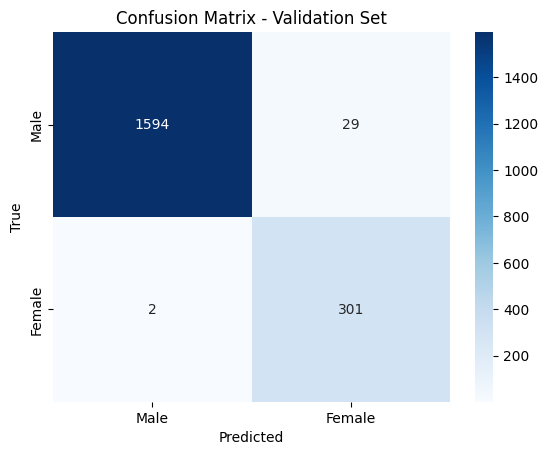

In [6]:
# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
